# MovieLens Recomendation

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset
from surprise import Reader
from surprise import SVD, SVDpp
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNWithZScore
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display, clear_output

## 加载数据

### Movies Data

movie.csv：包含电影信息
> movieId,title,genres
* `movieId`: 每个电影的唯一标识
* `title`: 电影的名称及其发布年份
* `genres`: 电影可能属于的类别，用|分隔

In [2]:
# movies data
# 包含9742部电影
# 需要把不同类别的电影分别分析
movies_df = pd.read_csv('Data/movies.csv')
print('Size of movies data:', movies_df.shape)
movies_df.head()

Size of movies data: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# 无缺失数据
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


### Ratings Data

ratings.csv:包含评分信息
> userId,movieId,rating,timestamp
* `userId`: 每个用户的唯一标识
* `movieId`: 每个用户的唯一标识
* `rating`: 评分
* `timestamp`: 时间戳

In [4]:
# ratings data
# 包含100836条评分
# timestamp用处不大
ratings_df = pd.read_csv('Data/ratings.csv')
print('Size of ratings data:', ratings_df.shape)
ratings_df.head()

Size of ratings data: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# 无缺失数据
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### Links Data

links.csv:包含链接中的电影标识信息
> movieId,imdbId,tmdbId
* `movieId`: https://movielens.org 中电影的唯一标识
* `imdbId`: http://www.imdb.com 中电影的唯一标识
* `tmdbId`: https://www.themoviedb.org 中电影的唯一标识

In [6]:
# Links data
# 9742部电影在三个数据源中的标识
links_df = pd.read_csv('Data/links.csv')
print('Size of links data:', links_df.shape)
links_df.head()

Size of links data: (9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Tags Data

tags.csv:包含电影标签信息
> userId,movieId,tag,timestamp
* `userId`: 每个用户的唯一标识
* `movieId`: 每个电影的唯一标识
* `tag`: 用户对于电影的标签短语
* `timestamp`: 时间戳

In [8]:
# tags data
# 3683条标签信息
tags_df = pd.read_csv('Data/tags.csv')
print('Size of tags data:', tags_df.shape)
tags_df.head()

Size of tags data: (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


## 数据分析

In [10]:
# 删除ratings和tags的timestamp
ratings_df.drop(columns='timestamp', inplace=True)
tags_df.drop(columns='timestamp', inplace=True)

In [11]:
# 均值约为3.5
ratings_df['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [12]:
ratings_df['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

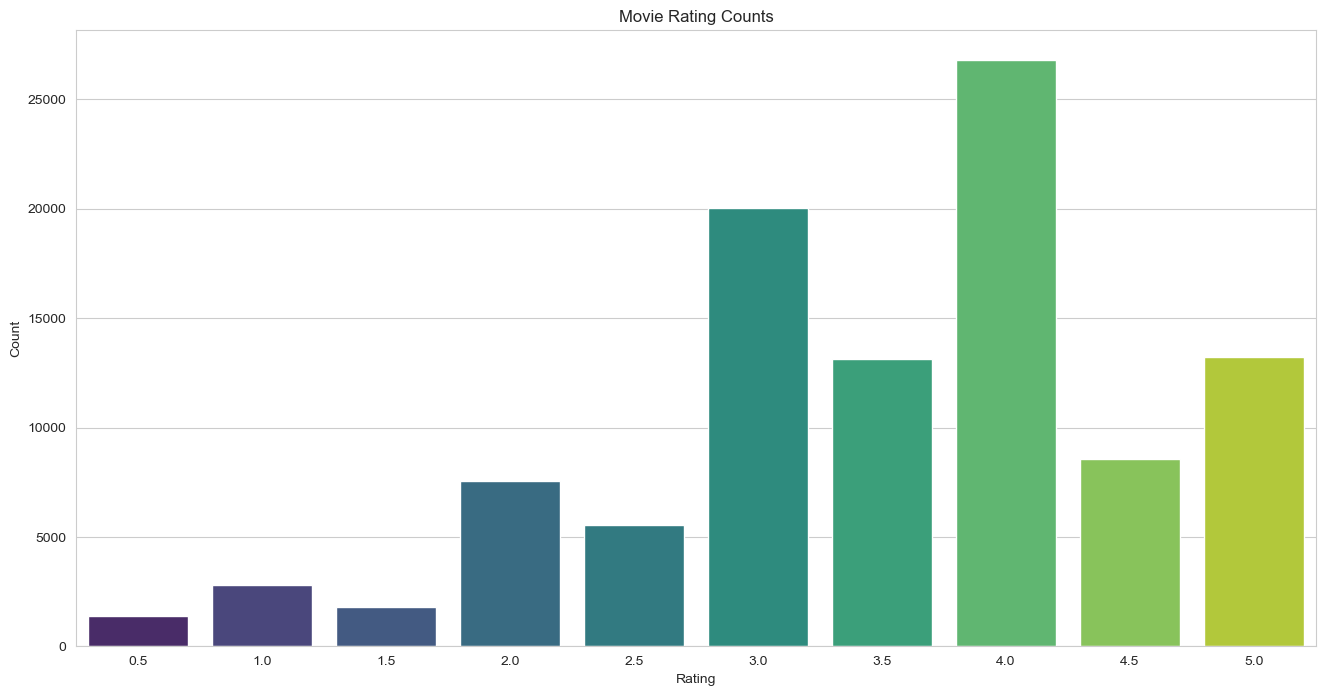

In [13]:
# 评分条形图
rating_counts = ratings_df['rating'].value_counts()
plt.figure(figsize=(16, 8))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="viridis")
# 图表标题和轴标签
plt.title('Movie Rating Counts')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('Images/movie_rating')
plt.show()

In [14]:
# 从电影标题中提取发行年份
movies_df['year'] = movies_df['title'].str.extract('.*\((.*)\).*',expand = False)

In [15]:
# 异常值：2006-2007、NaN
movies_df['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

In [16]:
# 查找年份为'2006-2007'的电影
movies_df[movies_df['year'] == "2006–2007"]

,movieId,title,genres,year
9518,171749,Death Note: Desu nôto (2006–2007),(no genres listed),2006–2007


In [17]:
# 更改为2007
movies_df['year'] = movies_df['year'].replace("2006–2007","2007")

In [18]:
# 查找没有年份信息的电影
movies_df[pd.isna(movies_df['year'])]

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [19]:
# 删除没有年份信息和的电影
movies_df = movies_df.dropna(subset=['year'],how='any')

In [20]:
# 将'year'列的数据类型转换为int
movies_df['year'] = movies_df['year'].astype(int)

In [21]:
movies_df['year'].describe()

count    9730.000000
mean     1994.614902
std        18.534692
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64

In [22]:
movies_df['year'].value_counts()

year
2002    311
2006    295
2001    294
2007    285
2000    283
       ... 
1917      1
1915      1
1919      1
1921      1
1908      1
Name: count, Length: 106, dtype: int64

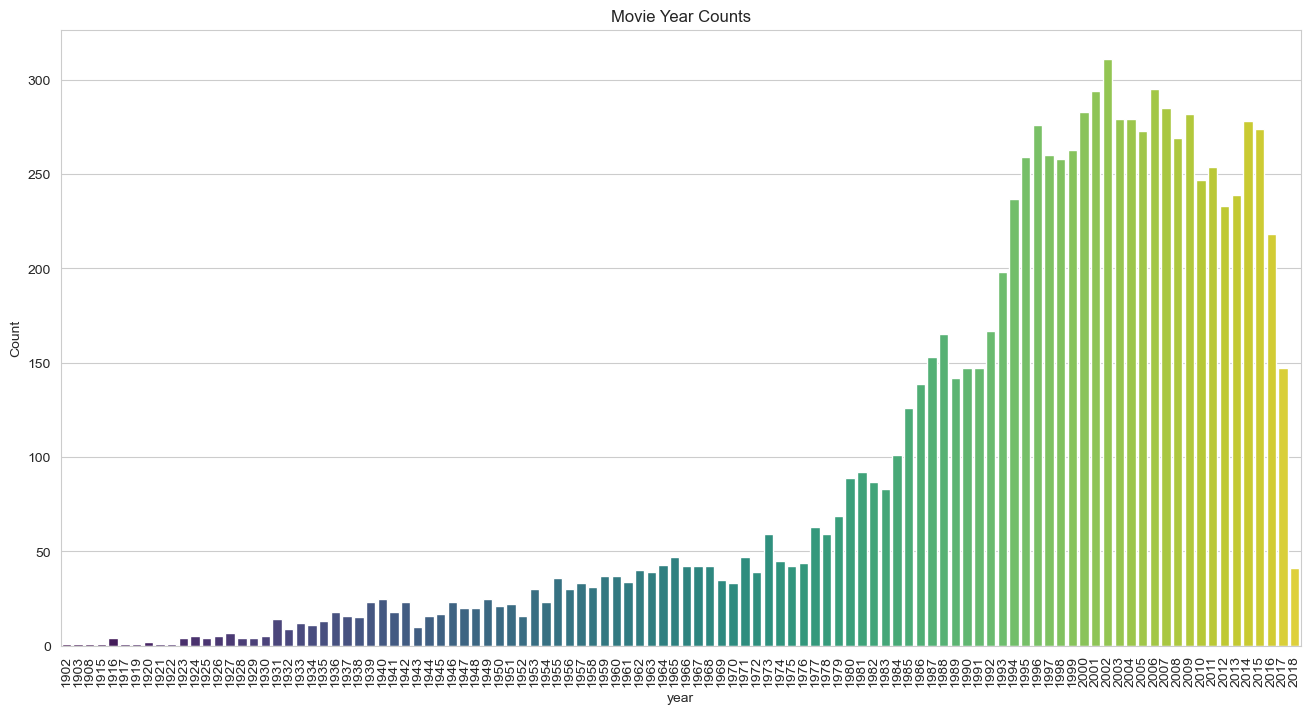

In [23]:
# 1902-2018年
# 评分条形图
movies_counts = movies_df['year'].value_counts()
plt.figure(figsize=(16, 8))
sns.barplot(x=movies_counts.index, y=movies_counts.values, palette="viridis")
# 图表标题和轴标签
plt.title('Movie Year Counts')
plt.xlabel('year')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.savefig('Images/movie_year')
plt.show()

In [24]:
# 重复值检查
# movieId?
movies_df["movieId"].is_unique

True

In [25]:
# title?
movies_df["title"].is_unique

False

In [26]:
# 5部同名电影
movies_df[movies_df.duplicated(["title"], keep=False)].sort_values(by="title")

,movieId,title,genres,year
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,2002
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,2002
650,838,Emma (1996),Comedy|Drama|Romance,1996
5601,26958,Emma (1996),Romance,1996
5854,32600,Eros (2004),Drama,2004
9135,147002,Eros (2004),Drama|Romance,2004
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,1980
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller,1980
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,2005
6932,64997,War of the Worlds (2005),Action|Sci-Fi,2005


In [27]:
# 替换重复电影标识
movie_id_change = {6003:144606, 838:26958, 32600:147002, 2851:168358, 34048:64997}
movies_df['movieId'].replace(movie_id_change,inplace=True)
movies_df = movies_df.drop_duplicates(subset=["movieId","title"])
ratings_df['movieId'].replace(movie_id_change,inplace=True)
tags_df['movieId'].replace(movie_id_change,inplace=True)
links_df['movieId'].replace(movie_id_change,inplace=True)

In [28]:
# title?
movies_df["title"].is_unique

True

In [29]:
# genre处理
movies_df['genres'] = movies_df['genres'].replace('(no genres listed)', np.nan)
movies_df['genres'].isna().sum()

26

In [30]:
# 删除缺失值
movies_df = movies_df.dropna(subset=['genres'],how='any')
movies_df = movies_df.reset_index(drop=True)

In [31]:
# 分隔类别
genres = []
for i in range(len(movies_df.genres)):
    for x in movies_df.genres[i].split('|'):
        if x not in genres:
            genres.append(x)
genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir']

In [32]:
# 独热编码
for x in genres:
    movies_df[x] = 0
for i in range(len(movies_df.genres)):
    for x in movies_df.genres[i].split('|'):
        movies_df[x][i]=1

In [33]:
# 删除genres列
movies_df.drop(columns='genres', inplace=True)
movies_df.sort_index(inplace=True)
movies_df

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),1995,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9694,193581,Black Butler: Book of the Atlantic (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9695,193583,No Game No Life: Zero (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9696,193585,Flint (2017),2017,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9697,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Animation             611
Children              664
Comedy               3755
Fantasy               779
Romance              1593
Drama                4357
Action               1826
Crime                1198
Thriller             1890
Horror                978
Mystery               573
Sci-Fi                976
War                   382
Musical               334
Documentary           440
IMAX                  158
Western               167
Film-Noir              87


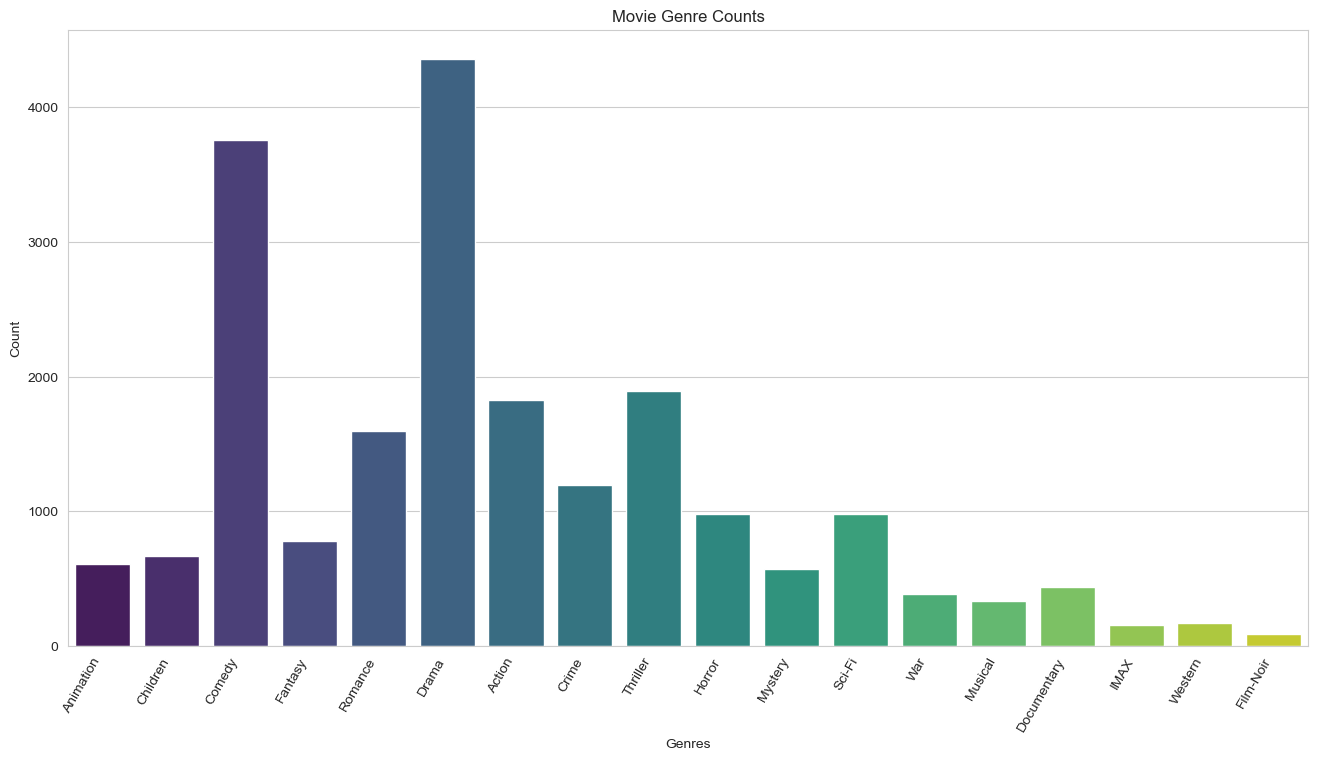

In [34]:
# plotting genres popularity
x = {}
for i in movies_df.columns[4:23]:
 x[i] = movies_df[i].sum()
 print(f"{i:<15}{x[i]:>10}")
plt.figure(figsize=(16,8))
sns.barplot(x=list(x.keys()), y=list(x.values()), palette="viridis")
# 图表标题和轴标签
plt.title('Movie Genre Counts')
plt.xlabel('Genres')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Count')
plt.savefig('Images/movie_genre')
plt.show()

In [35]:
# 统计平均评分和评分人数
mean_rating = ratings_df.groupby('movieId').rating.mean().rename('mean rating')
num_rating = ratings_df.groupby('movieId').userId.count().rename('num rating')
# 加入表中
movies_df = pd.merge(movies_df, mean_rating, how='left', on='movieId')
movies_df = pd.merge(movies_df, num_rating, how='left', on='movieId')
# 缺失补0
movies_df['mean rating'].fillna(0, inplace=True)
movies_df['num rating'].fillna(0, inplace=True)

movies_df[['title', 'mean rating', 'num rating']]

,title,mean rating,num rating
0,Toy Story (1995),3.920930,215.0
1,Jumanji (1995),3.431818,110.0
2,Grumpier Old Men (1995),3.259615,52.0
3,Waiting to Exhale (1995),2.357143,7.0
4,Father of the Bride Part II (1995),3.071429,49.0
...,...,...,...
9694,Black Butler: Book of the Atlantic (2017),4.000000,1.0
9695,No Game No Life: Zero (2017),3.500000,1.0
9696,Flint (2017),3.500000,1.0
9697,Bungo Stray Dogs: Dead Apple (2018),3.500000,1.0


## 基础推荐系统

In [36]:
movie_ratings = movies_df[['title', 'mean rating', 'num rating', ]]

In [37]:
# 最多评分电影
movie_ratings.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
314,Forrest Gump (1994),4.164134,329.0
277,"Shawshank Redemption, The (1994)",4.429022,317.0
257,Pulp Fiction (1994),4.197068,307.0
510,"Silence of the Lambs, The (1991)",4.161290,279.0
1939,"Matrix, The (1999)",4.192446,278.0
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
418,Jurassic Park (1993),3.750000,238.0
97,Braveheart (1995),4.031646,237.0
507,Terminator 2: Judgment Day (1991),3.970982,224.0
461,Schindler's List (1993),4.225000,220.0


In [38]:
# 最高评分电影
movie_ratings.sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
7598,Idiots and Angels (2008),5.0,1.0
8670,Stuart Little 3: Call of the Wild (2005),5.0,1.0
3110,Reform School Girls (1986),5.0,1.0
8501,"One I Love, The (2014)",5.0,1.0
8513,Laggies (2014),5.0,1.0
3081,"Monster Squad, The (1987)",5.0,1.0
8547,Crippled Avengers (Can que) (Return of the 5 D...,5.0,1.0
3067,Hollywood Shuffle (1987),5.0,1.0
8587,Watermark (2014),5.0,1.0
8606,Hellbenders (2012),5.0,1.0


In [39]:
# 设置最低评分数量的阈值
minimum_num_ratings = 100
movie_ratings[movie_ratings['num rating']>minimum_num_ratings].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
277,"Shawshank Redemption, The (1994)",4.429022,317.0
659,"Godfather, The (1972)",4.289062,192.0
2226,Fight Club (1999),4.272936,218.0
922,"Godfather: Part II, The (1974)",4.259690,129.0
6313,"Departed, The (2006)",4.252336,107.0
914,Goodfellas (1990),4.250000,126.0
6708,"Dark Knight, The (2008)",4.238255,149.0
46,"Usual Suspects, The (1995)",4.237745,204.0
899,"Princess Bride, The (1987)",4.232394,142.0
224,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0


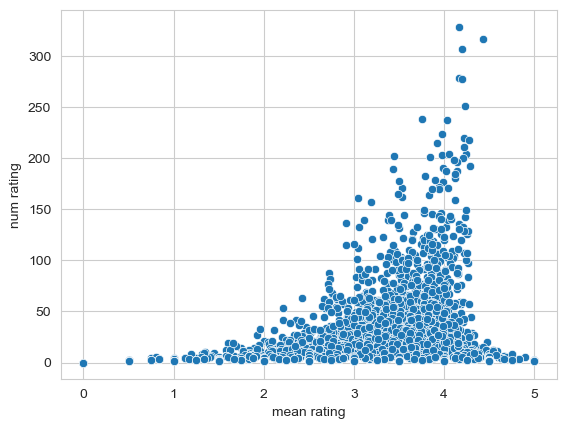

In [40]:
# 评分次数较高的电影与平均评分较高的关联性较高
sns.scatterplot(data=movies_df, x='mean rating', y ='num rating');
plt.savefig('Images/rating_relevance')

In [41]:
# 读者想要的特定类别
user_genre = 'Romance'
movie_ratings[movies_df[user_genre] == 1].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
9166,Spellbound (2011),5.0,1.0
3758,Seems Like Old Times (1980),5.0,1.0
8331,Only Lovers Left Alive (2013),5.0,1.0
8340,Chinese Puzzle (Casse-tête chinois) (2013),5.0,1.0
9167,Unicorn City (2012),5.0,1.0
4675,Jane Eyre (1944),5.0,1.0
5345,Raise Your Voice (2004),5.0,1.0
4251,Lady Jane (1986),5.0,1.0
8378,"Garden of Words, The (Koto no ha no niwa) (2013)",5.0,1.0
9121,The Girls (1961),5.0,1.0


In [42]:
# 设置最低评分数量的阈值
user_genre = 'Romance'
minimum_num_ratings = 100
movie_ratings[(movies_df[user_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
899,"Princess Bride, The (1987)",4.232394,142.0
3622,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.183333,120.0
314,Forrest Gump (1994),4.164134,329.0
4909,Eternal Sunshine of the Spotless Mind (2004),4.160305,131.0
1284,Good Will Hunting (1997),4.078014,141.0
6770,WALL·E (2008),4.057692,104.0
2145,American Beauty (1999),4.056373,204.0
3640,"Beautiful Mind, A (2001)",4.000000,123.0
964,Groundhog Day (1993),3.944056,143.0
3194,Shrek (2001),3.867647,170.0


In [43]:
def naive_recommendation(threshold,ch_genre):
    
    minimum_num_ratings = threshold
    if ch_genre == 'All':
        result = movie_ratings[(movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)    
    else:
        result = movie_ratings[(movies_df[ch_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)
    
    print('\n\nRecommendations System')
    print('Minimum number of ratings:',threshold)
    print("Choice of genre:",ch_genre)
    display(result)

    
genres = ['All',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir'
         ]

w = interactive(naive_recommendation, threshold=widgets.IntSlider(min=0, max=200, value=100, step=5),
                       ch_genre=widgets.Dropdown(options=genres, description="Genre")
               )
display(w)

interactive(children=(IntSlider(value=100, description='threshold', max=200, step=5), Dropdown(description='Ge…

## 协同过滤

In [44]:
df = pd.merge(ratings_df, movies_df, how='left', on = 'movieId')
# 创建矩阵：电影与用户
movie_user_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_user_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [45]:
movie_id = 900
movie_name = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
movie_name

'American in Paris, An (1951)'

In [46]:
movie_ratings_df = movie_user_matrix[movie_name]
movie_ratings_df.head()

userId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: American in Paris, An (1951), dtype: float64

In [47]:
correlation = movie_user_matrix.corrwith(movie_ratings_df)
similar_movies = pd.DataFrame(correlation, columns=['Correlation'])
# 删除缺失值
similar_movies.dropna(inplace=True)
similar_movies.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Superman III (1983),1.0
GoldenEye (1995),1.0
Singles (1992),1.0
Pollock (2000),1.0
"Darjeeling Limited, The (2007)",1.0
Simone (S1m0ne) (2002),1.0
To Sir with Love (1967),1.0
Ghost Rider (2007),1.0
"Ghost and Mrs. Muir, The (1947)",1.0


In [48]:
# 设置最低评分数量的阈值
similar_movies = pd.merge(similar_movies, movies_df[['title','num rating']].drop_duplicates(), left_index=True, right_on='title')
similar_movies.set_index('title', inplace=True)
threshold = 50
similar_movies.sort_values('Correlation', ascending=False)[similar_movies['num rating']>threshold].head(10)

,Correlation,num rating
title,,
GoldenEye (1995),1.0,132.0
Total Recall (1990),1.0,88.0
Blazing Saddles (1974),1.0,62.0
Field of Dreams (1989),1.0,56.0
In the Line of Fire (1993),1.0,70.0
City Slickers II: The Legend of Curly's Gold (1994),1.0,55.0
Django Unchained (2012),1.0,71.0
Casino Royale (2006),1.0,81.0
District 9 (2009),1.0,65.0


## surprise库

KNN 算法：
cv_knn_basic：使用 KNNBasic 算法进行交叉验证。这个算法是基于k最近邻的协同过滤算法，用于用户和物品之间的相似度计算。
cv_knn_means：使用 KNNWithMeans 算法进行交叉验证。考虑了用户的平均评分。
cv_knn_z：使用 KNNWithZScore 算法进行交叉验证。考虑了评分的z-score标准化。
矩阵分解算法：
cv_svd：使用 SVD 算法进行交叉验证。这个算法是一种矩阵分解算法，用于将用户和物品的评分矩阵分解为潜在特征。
cv_svd_pp：使用 SVDpp 算法进行交叉验证。包含了概率矩阵分解。

In [49]:
# 训练集数据准备
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings_df, reader)
dataset = data.build_full_trainset()
print('用户数量', dataset.n_users, '\n')
print('电影数量', dataset.n_items)

用户数量 610 

电影数量 9719


In [50]:
# knn算法
cv_knn_basic = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_means = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=True)
cv_knn_z = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9582  0.9416  0.9479  0.9487  0.9454  0.9484  0.0055  
MAE (testset)     0.7315  0.7242  0.7281  0.7278  0.7226  0.7268  0.0031  
Fit time          0.12    0.12    0.12    0.12    0.12    0.12    0.00    
Test time         0.92    0.91    0.90    0.92    0.91    0.91    0.01    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8992  0.8890  0.8955  0.9077  0.8911  0.8965  0.0066  
MAE (testset)     0.6881  0.6801  0.6834  0.6920  0.6814  0.6850  0.0044  
Fit time          0.13    0.13    0.13    0.13    0.13    0.13    0.00    
Test time         1.02    1.02    1.02    1.01    1.02    1.02    0.00    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [51]:
# 矩阵分解算法
cv_svd = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=True)
cv_svd_pp = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8780  0.8781  0.8701  0.8695  0.8731  0.8738  0.0037  
MAE (testset)     0.6746  0.6740  0.6683  0.6692  0.6724  0.6717  0.0025  
Fit time          0.69    0.68    0.69    0.68    0.68    0.69    0.00    
Test time         0.10    0.10    0.10    0.10    0.10    0.10    0.00    
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8625  0.8544  0.8612  0.8576  0.8662  0.8604  0.0041  
MAE (testset)     0.6605  0.6568  0.6583  0.6556  0.6658  0.6594  0.0036  
Fit time          69.83   70.55   70.44   71.82   71.18   70.76   0.68    
Test time         11.72   11.39   11.37   10.72   11.01   11.24   0.35    


In [52]:
# Printing out the results for these algoritms
print('Evaluation Results:')
print('Algoritm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(cv_knn_basic['test_rmse'].mean(), 4), '\t\t', round(cv_knn_basic['test_mae'].mean(), 4))
print('KNN Means', '\t', round(cv_knn_means['test_rmse'].mean(), 4), '\t', round(cv_knn_means['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(cv_knn_z['test_rmse'].mean(), 4), '\t\t', round(cv_knn_z['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(cv_svd['test_rmse'].mean(), 4), '\t', round(cv_svd['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(cv_svd_pp['test_rmse'].mean(), 4), '\t', round(cv_svd_pp['test_mae'].mean(), 4))

Evaluation Results:
Algoritm	 RMSE		 MAE

KNN Basic 	 0.9484 		 0.7268
KNN Means 	 0.8965 	 0.685
KNN ZScore 	 0.8977 		 0.681

SVD 		 0.8738 	 0.6717
SVDpp 		 0.8604 	 0.6594


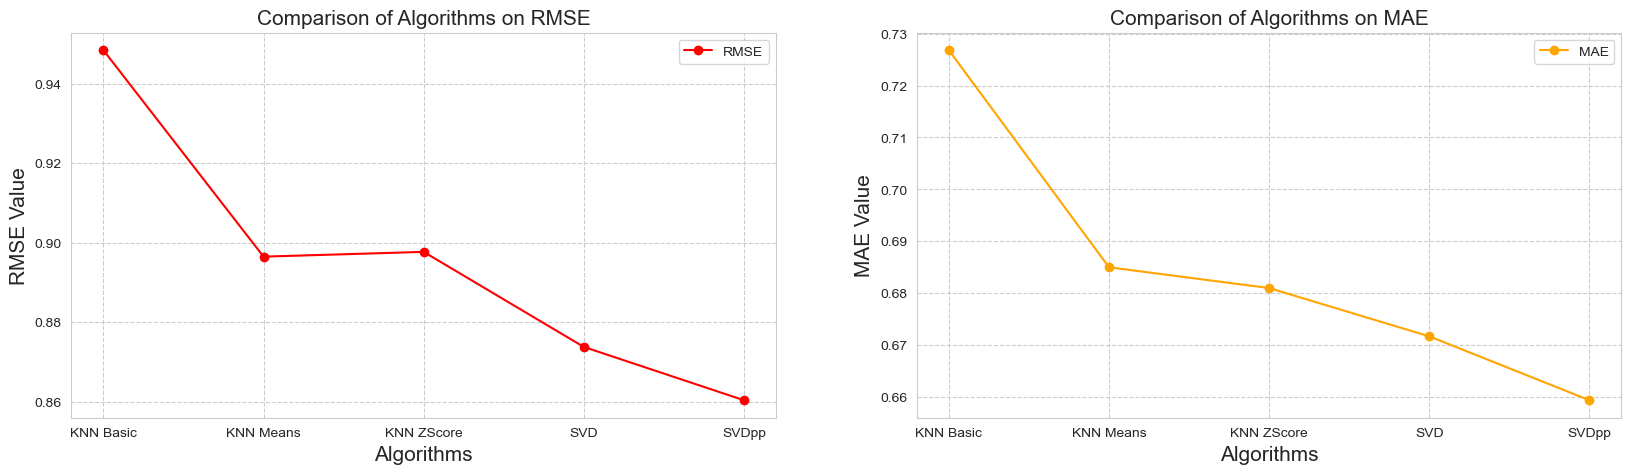

In [53]:
# 比较不同算法
# 选择 KNN ZScore 和 SVDpp
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp',]
all_algos_cv = [cv_knn_basic, cv_knn_means, cv_knn_z, cv_svd, cv_svd_pp]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

# RMSE
plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='red', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

# MAE
plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='orange', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.savefig('Images/RMSE_MAE')
plt.show()

## KNN Based Algorithms

I will now optimize on these two models. Let's start with KNN Means. We will optimize two hyperparameters: `k(numver of neighbors` and `distance metric`.First, I search for optimal `k` between 5 and 100.

In [54]:
# 网格搜索最近邻数量
param_grid = {'k': [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]}

gs_knn_zscore = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_knn_zscore.fit(data)

y1 = gs_knn_zscore.cv_results['mean_test_rmse']
y2 = gs_knn_zscore.cv_results['mean_test_mae']

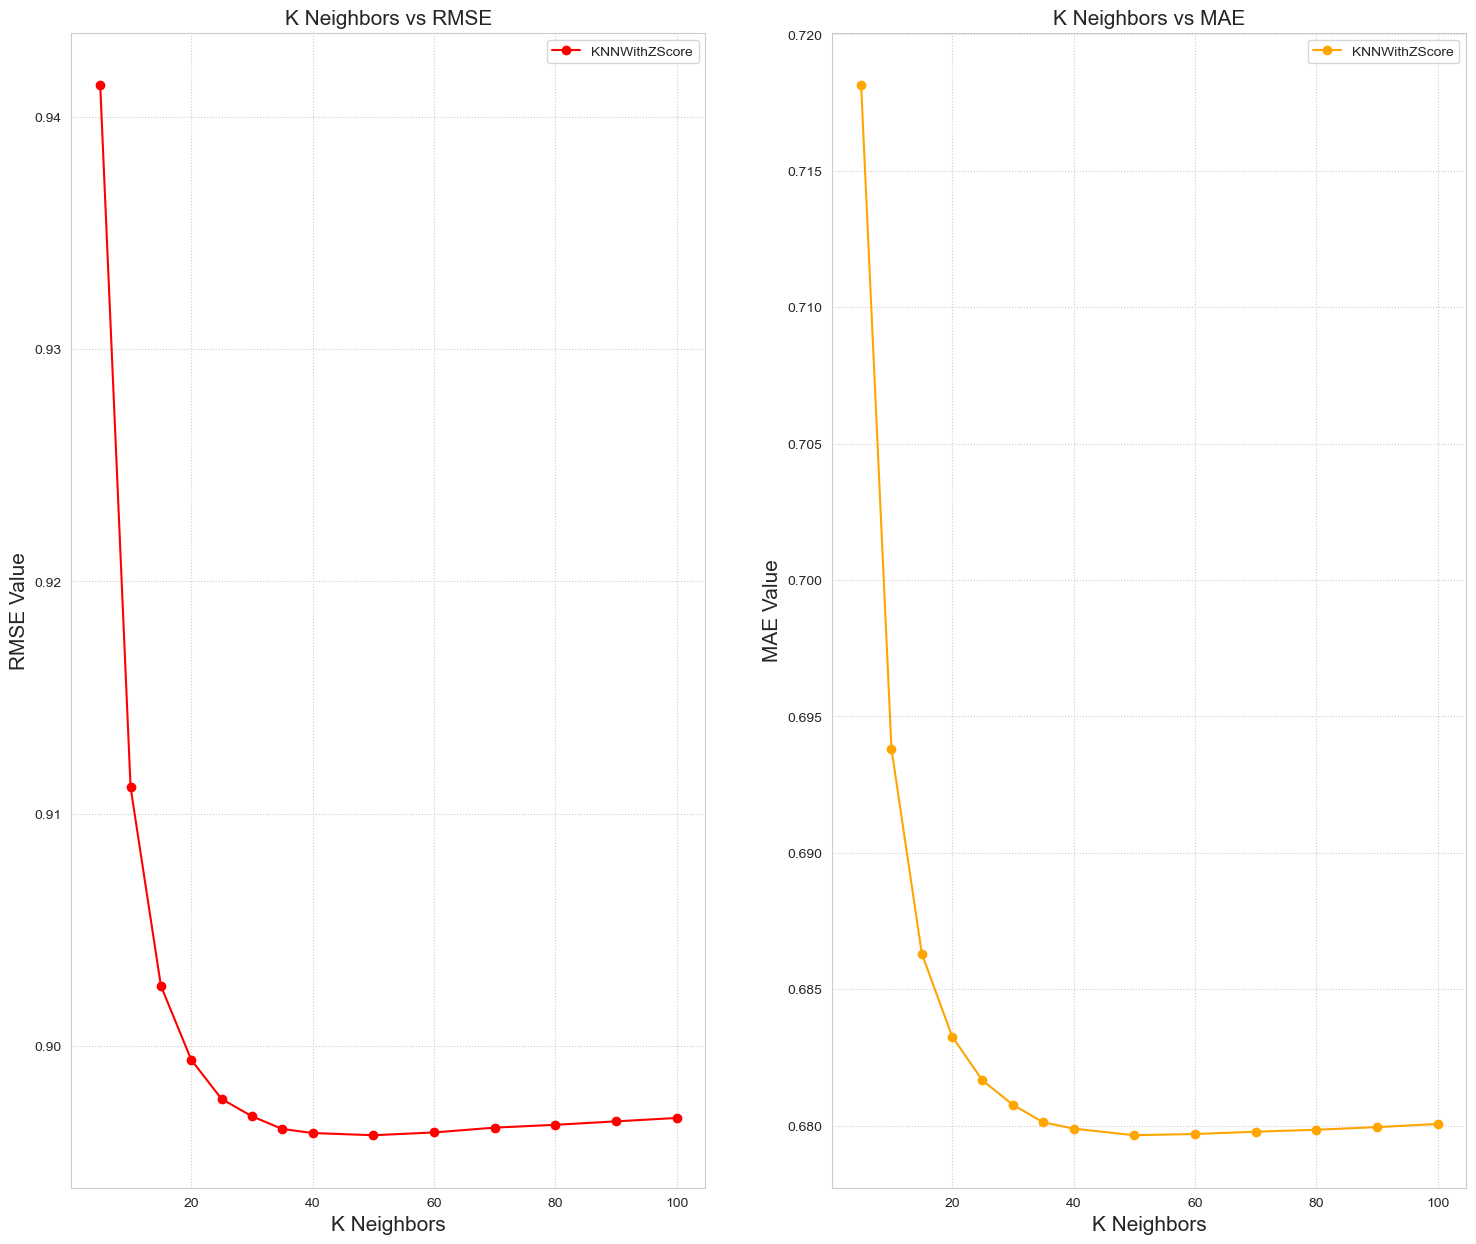

In [55]:
# 绘图
plt.figure(figsize = (18, 15))

x = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNWithZScore', color='red', marker='o')
plt.xlabel('K Neighbors', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNWithZScore', color='orange', marker='o')
plt.xlabel('K Neighbors', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')
plt.savefig('Images/K vs RMSE_MAE')
plt.show()

In [56]:
# 最优k值为50
best_k1 = gs_knn_zscore.best_params['rmse']['k']
print("最优的k值:", best_k1)
best_k2 = gs_knn_zscore.best_params['mae']['k']
print("最优的k值:", best_k2)

最优的k值: 50
最优的k值: 50


Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8981  0.9013  0.9044  0.8925  0.8959  0.8984  0.0041  
MAE (testset)     0.6808  0.6847  0.6848  0.6787  0.6800  0.6818  0.0025  
Fit time          0.72    0.74    0.72    0.72    0.72    0.72    0.01    
Test time         2.10    2.09    2.06    2.12    2.08    2.09    0.02    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9001  0.8969  0.8947  0.9007  0.8912  0.8967  0.0035  
MAE (testset)     0.6826  0.6761  0.6753  0.6776  0.6725  0.6768  0.0033  
Fit time          0.79    0.91    0.79    0.79    0.77    0.81    0.05    
Test time         2.04    2.02    2.04    2.03    2.03    2.03    0.01    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  

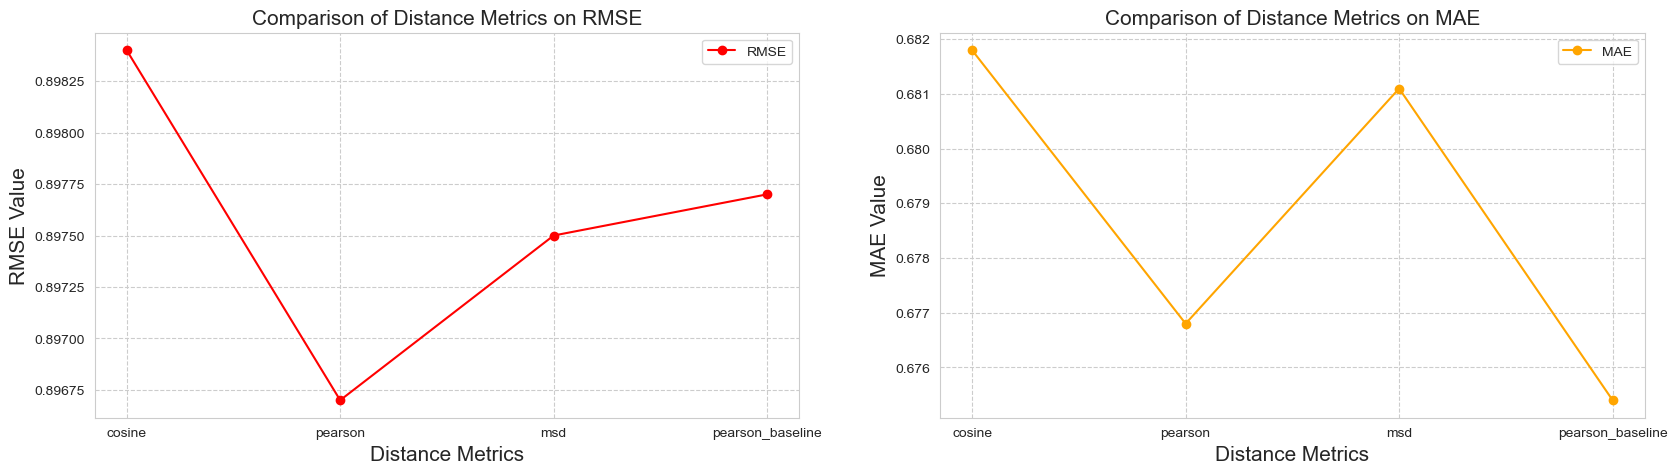

In [57]:
# 距离矩阵
knn_means_cosine = cross_validate(KNNWithZScore(k=50, sim_options={'name':'cosine'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_pearson = cross_validate(KNNWithZScore(k=50, sim_options={'name':'pearson'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_msd = cross_validate(KNNWithZScore(k=50, sim_options={'name':'msd'}), data, cv=5, n_jobs=5, verbose=True)
knn_means_pearson_baseline = cross_validate(KNNWithZScore(k=50, sim_options={'name':'pearson_baseline'}), data, cv=5, n_jobs=5, verbose=True)


x_distance = ['cosine', 'pearson', 'msd', 'pearson_baseline',]
all_distances_cv = [knn_means_cosine, knn_means_pearson, knn_means_msd, knn_means_pearson_baseline]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_distances_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_distances_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Distance Metrics on RMSE', loc='center', fontsize=15)
plt.plot(x_distance, rmse_cv, label='RMSE', color='red', marker='o')
plt.xlabel('Distance Metrics', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Distance Metrics on MAE', loc='center', fontsize=15)
plt.plot(x_distance, mae_cv, label='MAE', color='orange', marker='o')
plt.xlabel('Distance Metrics', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.savefig('Images/Distance_metrics')
plt.show()

KNN-ZScore with k=50 and pearson

 - **RMSE**: 0.8955
 - **MAE** : 0.6765

In [58]:
svd_param_grid = {'n_epochs': [20, 25, 30, 40, 50],
                  'lr_all': [0.007, 0.009, 0.01, 0.02],
                  'reg_all': [0.02, 0.04, 0.1, 0.2]}

gs_svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
gs_svd.fit(data)


In [59]:
print('Best value for SVD  -RMSE:', round(gs_svd.best_score['rmse'], 4), '; MAE:', round(gs_svd.best_score['mae'], 4))
print('Optimal params RMSE =', gs_svd.best_params['rmse'])
print('optimal params MAE =', gs_svd.best_params['mae'])

Best value for SVD  -RMSE: 0.8499 ; MAE: 0.6513
Optimal params RMSE = {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}
optimal params MAE = {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


### Predictions

In [60]:
from surprise.model_selection import train_test_split
from surprise import accuracy

# 划分数据集为训练集和测试集
trainset, testset = train_test_split(data, test_size=0.3,random_state=42)

# 创建并训练 KNNWithZScore 模型
final_knn_model = KNNWithZScore(k=50, sim_options={'name': 'pearson'})
final_knn_model.fit(trainset)

# 在测试集上进行预测
predictions = final_knn_model.test(testset)

# 计算 RMSE 和 MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9046
MAE:  0.6832


In [61]:
final_svdd_model = SVD(n_epochs=50, lr_all=0.01, reg_all=0.1)
final_svdd_model.fit(trainset)

# 在测试集上进行预测
predictions = final_svdd_model.test(testset)

# 计算 RMSE 和 MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8572
MAE:  0.6576


In [62]:
final_svd_model = SVDpp(n_epochs=50, lr_all=0.01, reg_all=0.1)
final_svd_model.fit(trainset)

# 在测试集上进行预测
predictions = final_svd_model.test(testset)

# 计算 RMSE 和 MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8592
MAE:  0.6593


 SVD 模型的 MAE 和 RMSE 更低

In [138]:
def get_movie_recommendations(user_id, top_N=10):
    # 获取目标用户未评级的电影
    # 获取测试集中的所有电影
    # 筛选出测试集中属于目标用户的数据
    testset_movie = [item for item in testset]
    # 获取目标用户在测试集中观看的电影列表
    movie_list = [item[1] for item in testset_movie]

    # 为目标用户生成推荐列表
    recommendations = []
    for movie_id in movie_list:
        estimated_rating = final_svdd_model.predict(user_id, movie_id).est
        recommendations.append((movie_id, estimated_rating))

    # 根据预测评分降序排序推荐列表
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # 获取前N部推荐电影
    top_recommendations = recommendations[:top_N]

    return top_recommendations

In [161]:
# 输入目标用户ID，获取电影推荐
user_id = 555  # 替换为您的目标用户ID
top_N = 100  # 替换为您想要的推荐数量
recommendations = get_movie_recommendations(user_id, top_N)
print("用户", user_id, "的电影推荐：")
for movie_id, estimated_rating in recommendations:
    print("电影ID:", movie_id, "预测评分:", estimated_rating)

用户 555 的电影推荐：
电影ID: 3498 预测评分: 4.690905090415696
电影ID: 3498 预测评分: 4.690905090415696
电影ID: 3265 预测评分: 4.645384520211538
电影ID: 3265 预测评分: 4.645384520211538
电影ID: 3265 预测评分: 4.645384520211538
电影ID: 3265 预测评分: 4.645384520211538
电影ID: 1041 预测评分: 4.59673832170785
电影ID: 1041 预测评分: 4.59673832170785
电影ID: 951 预测评分: 4.586865107731847
电影ID: 951 预测评分: 4.586865107731847
电影ID: 951 预测评分: 4.586865107731847
电影ID: 2007 预测评分: 4.586633335676098
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260873953
电影ID: 318 预测评分: 4.573682260

In [162]:
# 筛选出测试集中属于目标用户的数据
testset_for_user = [item for item in testset if item[0] == user_id]
# 获取目标用户在测试集中观看的电影列表
target_movie_list = [item[1] for item in testset_for_user]
target_movie_list

[1359,
 3706,
 2016,
 435,
 737,
 3840,
 2451,
 2478,
 3697,
 4042,
 1711,
 849,
 3258,
 419,
 410,
 1,
 145,
 788,
 1541,
 2018,
 3388,
 3649,
 1440,
 296,
 1663,
 790,
 1037,
 1784,
 32,
 3243,
 3662,
 3210,
 329,
 2288,
 3394,
 2110,
 1287,
 39,
 667,
 231,
 2916,
 2471,
 499,
 2085,
 2371,
 674,
 1983,
 577,
 3,
 1772,
 2460,
 160,
 3704,
 3051,
 1275,
 1970,
 2378,
 2572,
 3984,
 185,
 720,
 3206,
 4043,
 866,
 4010,
 2124,
 2359,
 1390,
 2498,
 3705,
 1220,
 969,
 1517,
 2641,
 2149,
 1971,
 2344,
 1259,
 926,
 3500,
 339,
 2469,
 293,
 1265,
 3844,
 218,
 1393,
 597,
 420,
 1210,
 1397,
 3783,
 2826,
 1240,
 2150,
 542,
 2639,
 968,
 1569,
 1991,
 1266,
 3694,
 2527,
 2346,
 778,
 2513,
 3412,
 3672,
 3395,
 3111,
 3917,
 1985,
 2407,
 1333,
 2133,
 440,
 3708,
 3574,
 2262,
 2672,
 2531,
 3678,
 2248,
 3793,
 4003,
 800,
 3250,
 1542,
 155,
 1214,
 1356,
 1375,
 2312,
 593,
 2470,
 2352,
 2762,
 543,
 3408,
 314,
 3809,
 2423,
 2735,
 2792,
 1777,
 1200,
 3197,
 1374,
 1088,
 1

In [163]:
# 计算推荐命中次数
hit = sum(1 for movie_id, _ in recommendations if movie_id in target_movie_list)
hit

2

In [164]:
precision = hit / len(recommendations)
recall = hit / len(target_movie_list)
print('Precision=%.3f, Recall=%.3f' % (precision, recall))

Precision=0.020, Recall=0.011


## 混合推荐引擎

In [165]:
def hybrid_recommendation_engine(user_id='new',preferred_genre='all',minimum_num_ratings=50):
    
    if user_id=='new':
        if preferred_genre == 'all':
            result = movie_ratings[(movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)    
        else:
            result = movie_ratings[(movies_df[preferred_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)

    else:
        new_df = df.copy()
    
        # 选择类别
        if preferred_genre !='all':
            new_df = new_df[new_df[preferred_genre]==1]

        # 评分数量过滤
        new_df = new_df[new_df['num rating']>=minimum_num_ratings]

        # 已评分电影过滤
        movies_already_watched = set(new_df[new_df['userId']==user_id].movieId.values)
        new_df= new_df[~new_df['movieId'].isin(movies_already_watched)]

        # 预测评分
        all_movie_ids = set(new_df['movieId'].values)
        all_movie_ratings = []

        for i in all_movie_ids:
            expected_rating = final_svdd_model.predict(uid=user_id, iid=i).est
            all_movie_ratings.append((i,round(expected_rating,1)))

        # 过滤出结果
        expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
        result = pd.merge(expected_df, movies_df[['movieId','title','num rating']],on='movieId')
        result = result.sort_values(['Expected Rating','num rating'],ascending=[False,False])
        result = result.head()
    
    
    print('\n\nRecommendations System')
    print('User id:',user_id)
    print('Minimum number of ratings:',minimum_num_ratings)
    print("Choice of genre:", preferred_genre)
    display(result)


        
genres = ['all',
          'Animation',
          'Children',
          'Comedy',
          'Fantasy',
          'Romance',
          'Drama',
          'Action',
          'Crime',
          'Thriller',
          'Horror',
          'Mystery',
          'Sci-Fi',
          'War',
          'Musical',
          'Documentary',
          'IMAX',
          'Western',
          'Film-Noir'
         ]
all_userids = ['new'] + list(set(df.userId.values))
w = interactive(hybrid_recommendation_engine,
                user_id=widgets.Dropdown(options=all_userids, description="user_id"),
                minimum_num_ratings=widgets.IntSlider(min=0, max=200, value=100, step=5),
                preferred_genre=widgets.Dropdown(options=genres, description="Genre")
               )
display(w)

interactive(children=(Dropdown(description='user_id', options=('new', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…